## Download Dataset

In [ ]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

--2021-05-06 16:04:20--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.78.216.154, 2600:1417:8000:980::e59, 2600:1417:8000:9b2::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.78.216.154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_3367a.zip’

kagglecatsanddogs_3 100%[===================>] 786.68M   187MB/s    in 4.3s    

2021-05-06 16:04:24 (183 MB/s) - ‘kagglecatsanddogs_3367a.zip’ saved [824894548/824894548]



## Unzip the Dataset

In [1]:
# !unzip kagglecatsanddogs_3367a.zip

## Import Modules

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import tqdm
import random
from keras.preprocessing.image import load_img
warnings.filterwarnings('ignore')

## Create Dataframe for Input and Output

In [ ]:
input_path = []
label = []

for class_name in os.listdir("PetImages"):
    for path in os.listdir("PetImages/"+class_name):
        if class_name == 'Cat':
            label.append(0)
        else:
            label.append(1)
        input_path.append(os.path.join("PetImages", class_name, path))
print(input_path[0], label[0])

PetImages/Dog/4253.jpg 1


In [ ]:
df = pd.DataFrame()
df['images'] = input_path
df['label'] = label
df = df.sample(frac=1).reset_index(drop=True)
df.head()

images  label
0    PetImages/Dog/67.jpg      1
1  PetImages/Dog/8273.jpg      1
2  PetImages/Dog/9117.jpg      1
3   PetImages/Cat/654.jpg      0
4  PetImages/Cat/6418.jpg      0

In [ ]:
for i in df['images']:
    if '.jpg' not in i:
        print(i)

PetImages/Cat/Thumbs.db
PetImages/Dog/Thumbs.db


In [ ]:
import PIL
l = []
for image in df['images']:
    try:
        img = PIL.Image.open(image)
    except:
        l.append(image)
l

['PetImages/Cat/666.jpg',
 'PetImages/Cat/Thumbs.db',
 'PetImages/Dog/Thumbs.db',
 'PetImages/Dog/11702.jpg']

In [ ]:
# delete db files
df = df[df['images']!='PetImages/Dog/Thumbs.db']
df = df[df['images']!='PetImages/Cat/Thumbs.db']
df = df[df['images']!='PetImages/Cat/666.jpg']
df = df[df['images']!='PetImages/Dog/11702.jpg']
len(df)

24998

## Exploratory Data Analysis

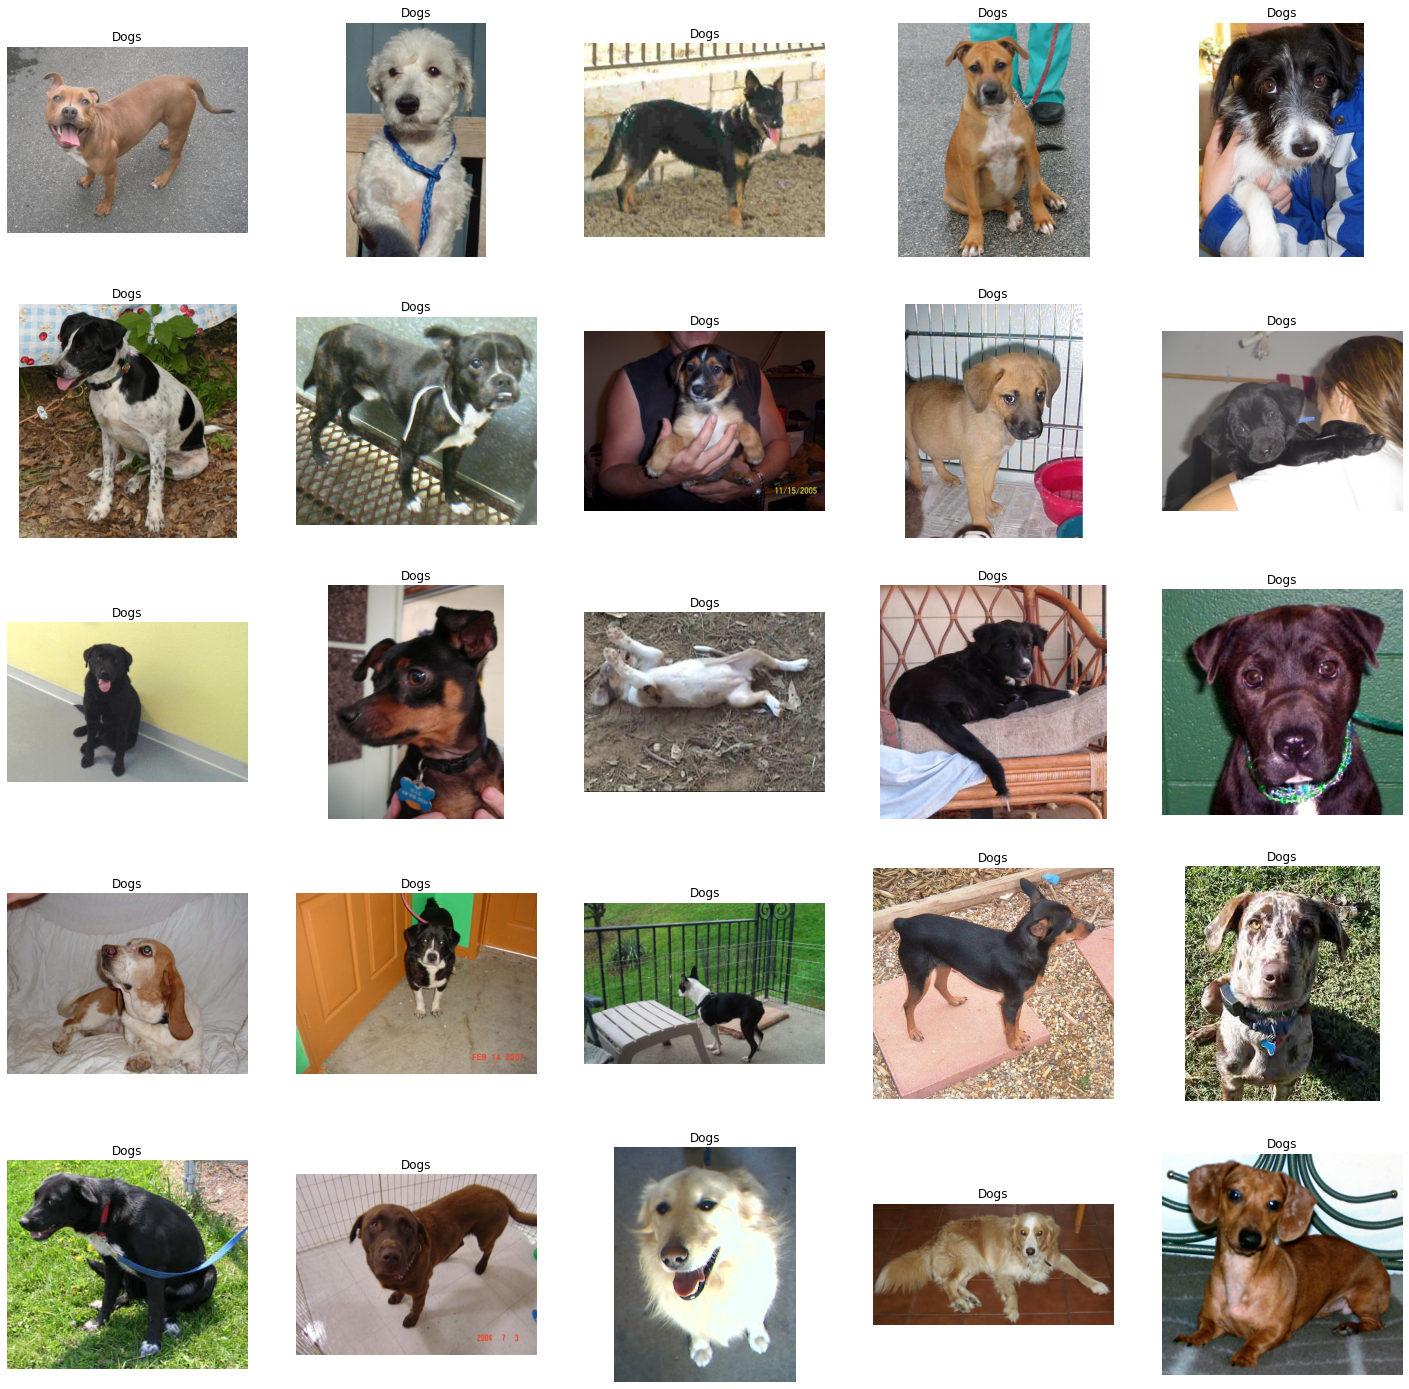

In [ ]:
# to display grid of images
plt.figure(figsize=(25,25))
temp = df[df['label']==1]['images']
start = random.randint(0, len(temp))
files = temp[start:start+25]

for index, file in enumerate(files):
    plt.subplot(5,5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title('Dogs')
    plt.axis('off')

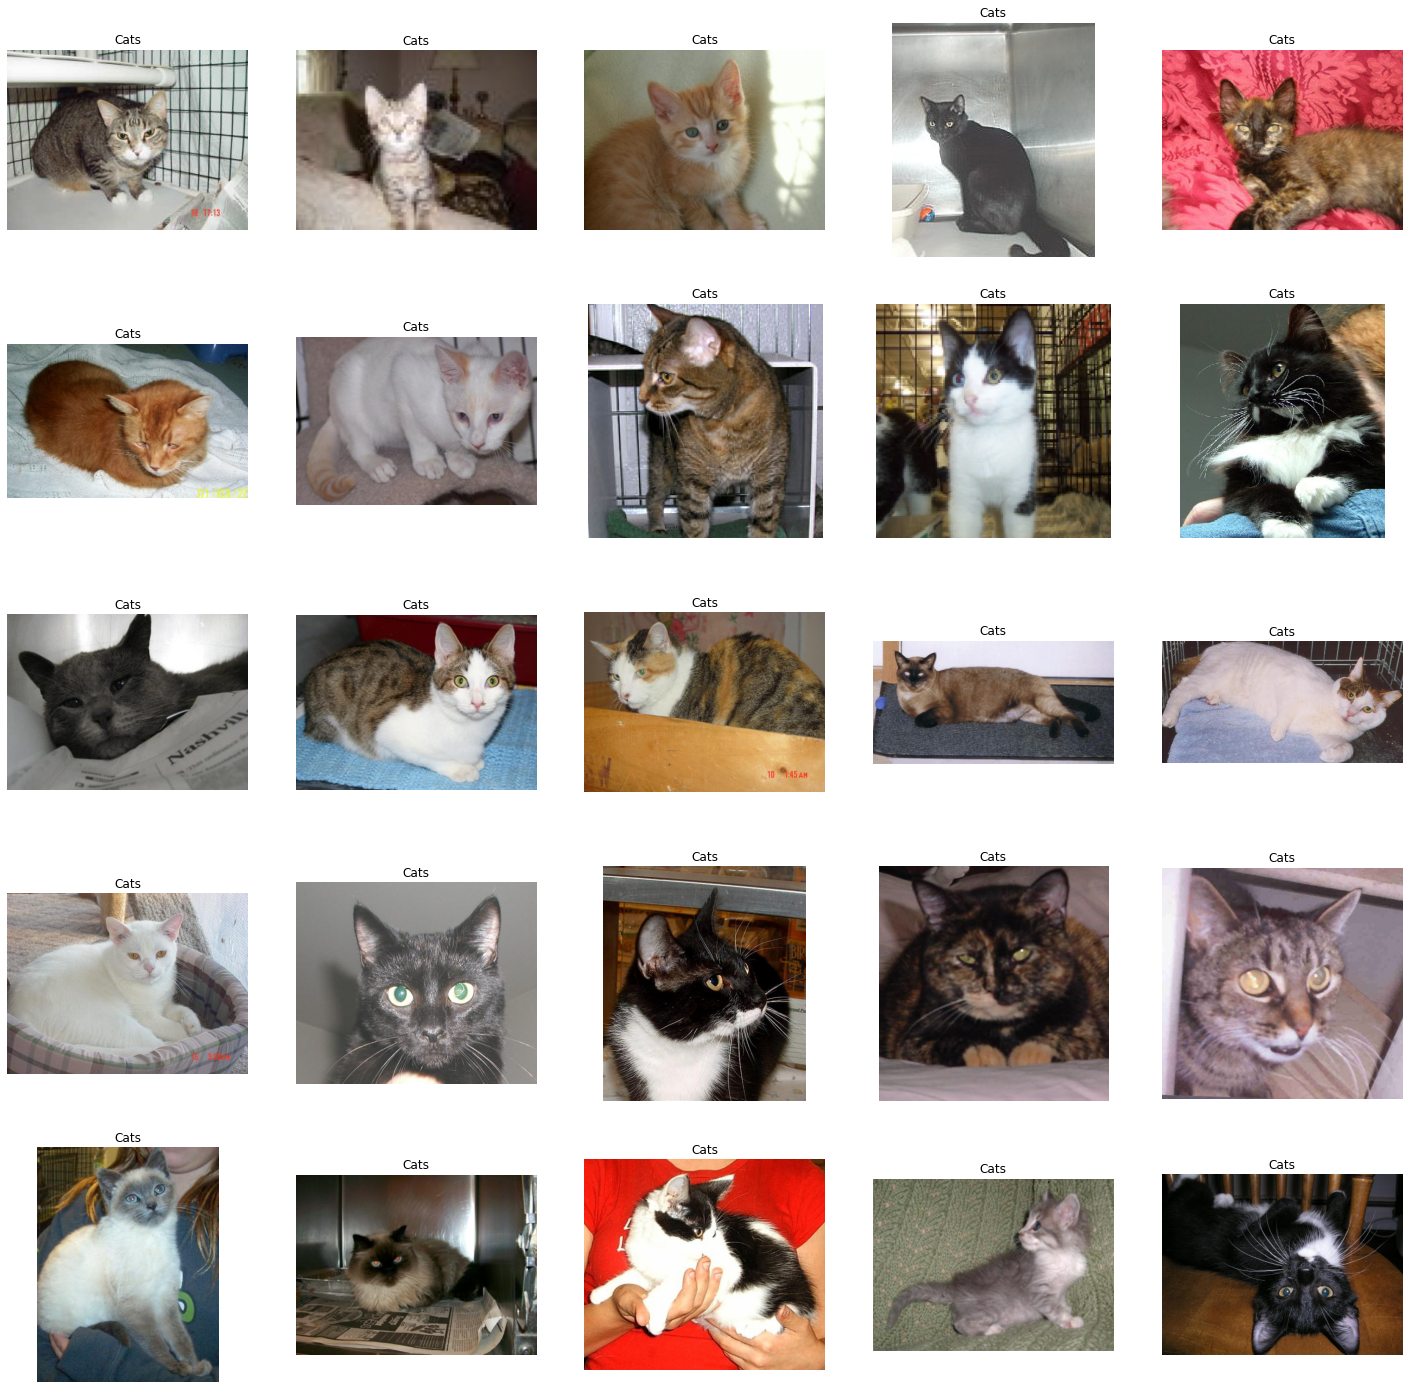

In [ ]:
# to display grid of images
plt.figure(figsize=(25,25))
temp = df[df['label']==0]['images']
start = random.randint(0, len(temp))
files = temp[start:start+25]

for index, file in enumerate(files):
    plt.subplot(5,5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title('Cats')
    plt.axis('off')

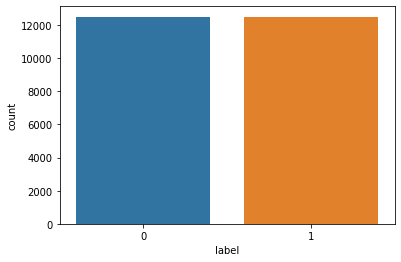

In [ ]:
import seaborn as sns
sns.countplot(df['label'])

## Create DataGenerator for the Images

In [ ]:
df['label'] = df['label'].astype('str')

In [ ]:
df.head()

images label
0    PetImages/Dog/67.jpg     1
1  PetImages/Dog/8273.jpg     1
2  PetImages/Dog/9117.jpg     1
3   PetImages/Cat/654.jpg     0
4  PetImages/Cat/6418.jpg     0

In [ ]:
# input split
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
    rescale = 1./255,  # normalization of images
    rotation_range = 40, # augmention of images to avoid overfitting
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

val_generator = ImageDataGenerator(rescale = 1./255)

train_iterator = train_generator.flow_from_dataframe(
    train, 
    x_col='images', 
    y_col='label', 
    target_size=(128,128), 
    batch_size=512, 
    class_mode='binary'
)

val_iterator = val_generator.flow_from_dataframe(
    test, 
    x_col='images', 
    y_col='label', 
    target_size=(128,128), 
    batch_size=512, 
    class_mode='binary'
)

Found 19998 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


## Model Creation

In [ ]:
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense

model = Sequential([
                    Conv2D(16, (3,3), activation='relu', input_shape=(128,128,3)),
                    MaxPool2D((2,2)),
                    Conv2D(32, (3,3), activation='relu'),
                    MaxPool2D((2,2)),
                    Conv2D(64, (3,3), activation='relu'),
                    MaxPool2D((2,2)),
                    Flatten(),
                    Dense(512, activation='relu'),
                    Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 12544)            

In [ ]:
history = model.fit(train_iterator, epochs=10, validation_data=val_iterator)

Epoch 1/10
40/40 [==============================] - 150s 4s/step - loss: 0.8679 - accuracy: 0.5187 - val_loss: 0.6399 - val_accuracy: 0.6238
Epoch 2/10
40/40 [==============================] - 147s 4s/step - loss: 0.6280 - accuracy: 0.6416 - val_loss: 0.5672 - val_accuracy: 0.7024
Epoch 3/10
40/40 [==============================] - 146s 4s/step - loss: 0.5737 - accuracy: 0.6980 - val_loss: 0.5493 - val_accuracy: 0.7148
Epoch 4/10
40/40 [==============================] - 146s 4s/step - loss: 0.5478 - accuracy: 0.7221 - val_loss: 0.5351 - val_accuracy: 0.7356
Epoch 5/10
40/40 [==============================] - 145s 4s/step - loss: 0.5276 - accuracy: 0.7338 - val_loss: 0.5104 - val_accuracy: 0.7494
Epoch 6/10
40/40 [==============================] - 144s 4s/step - loss: 0.5127 - accuracy: 0.7405 - val_loss: 0.4853 - val_accuracy: 0.7664
Epoch 7/10
40/40 [==============================] - 144s 4s/step - loss: 0.5059 - accuracy: 0.7544 - val_loss: 0.4586 - val_accuracy: 0.7868
Epoch 8/10
40

## Visualization of Results

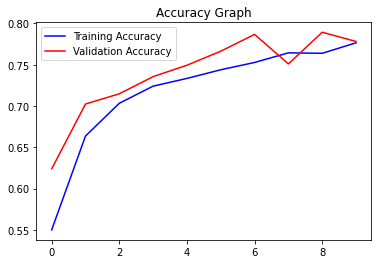

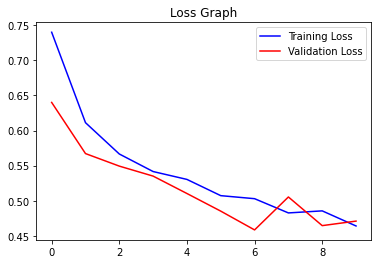

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

## Test with Real Image

In [ ]:
image_path = "test.jpg" # path of the image
img = load_img(image_path, target_size=(128, 128))
img = np.array(img)
img = img / 255.0 # normalize the image
img = img.reshape(1, 128, 128, 3) # reshape for prediction
pred = model.predict(img)
if pred[0] > 0.5:
    label = 'Dog'
else:
    label = 'Cat'
print(label)